In [1]:
import os
import gc
import mne
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

from threading import Thread
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
autodfname = 'auto_path_table.json'
autodf = pd.read_json(autodfname)
autodf

emnoises  \
EEG_S01                                                 []   
EEG_S02                                                 []   
EEG_S03                                                 []   
EEG_S04                                                 []   
EEG_S05               [Noise-default_Noise_20200107_02.ds]   
EEG_S06                                                 []   
EEG_S07                                                 []   
EEG_S08                                                 []   
EEG_S09                                                 []   
EEG_S10                                                 []   
MEG_S01  [Noise-default_Noise_20190326_01.ds, Noise-def...   
MEG_S02  [Noise-default_Noise_20190326_01.ds, Noise-def...   
MEG_S03               [Noise-default_Noise_20191231_02.ds]   
MEG_S04               [Noise-default_Noise_20191231_02.ds]   
MEG_S05                                                 []   
MEG_S06               [Noise-default_Noise_20200107_02.ds]   
MEG_S07               [Noise-default_Noise_20200107_02.ds]   
MEG_S08               [Noise-default_Noise_20200110_03.ds]   
MEG_S09                                                 []   
MEG_S10               [Noise-default_Noise_20200110_03.ds]   

                                                      raws  \
EEG_S01  {'10': '20190402_RSVP_EEG_S01/10.cnt', '02': '...   
EEG_S02  {'10': '20190402_RSVP_EEG_S02/10.cnt', '02': '...   
EEG_S03  {'10': '20191230_RSVP_EEG_S03/10.cnt', '11': '...   
EEG_S04  {'10': '20200104_RSVP_EEG_S04/10.cnt', '11': '...   
EEG_S05  {'10': '20200107-RSVP_EEG_S05/10.cnt', '11': '...   
EEG_S06  {'10': '20200106_RSVP_EEG_S06/10.cnt', '11': '...   
EEG_S07  {'10': '20200106_RSVP_EEG_S07/10.cnt', '11': '...   
EEG_S08  {'10': '20200111-RSVP_EEG_S08/10.cnt', '11': '...   
EEG_S09  {'10': '20200104_RSVP_EEG_S09/10.cnt', '11': '...   
EEG_S10  {'10': '20200116-RSVP_EEG_S10/10.cnt', '11': '...   
MEG_S01  {'04': '20190326_RSVP_MEG_S01/S01_lixiangTHU_2...   
MEG_S02  {'04': '20190326_RSVP_MEG_S02/S02_lixiangTHU_2...   
MEG_S03  {'03': '20191231_RSVP_MEG_S03/S02_G25IA_201912...   
MEG_S04  {'03': '20191231_RSVP_MEG_S04/S01_G25IA_201912...   
MEG_S05  {'03': '20200108_RSVP_MEG_S05/S05_G25IA_202001...   
MEG_S06  {'03': '20200107_RSVP_MEG_S06/S03_G25IA_202001...   
MEG_S07  {'03': '20200107_RSVP_MEG_S07/S04_G25IA_202001...   
MEG_S08  {'04': '20200110_RSVP_MEG_S08/S07_G25IA_202001...   
MEG_S09  {'04': '20200108_RSVP_MEG_S09/S06_G25IA_202001...   
MEG_S10  {'03': '20200110_RSVP_MEG_S10/S08_G25IA_202001...   

                                                  restings  
EEG_S01                                                 []  
EEG_S02                                                 []  
EEG_S03  [20191230_RSVP_EEG_S03/r1.cnt, 20191230_RSVP_E...  
EEG_S04  [20200104_RSVP_EEG_S04/r1.cnt, 20200104_RSVP_E...  
EEG_S05  [20200107-RSVP_EEG_S05/r1.cnt, 20200107-RSVP_E...  
EEG_S06  [20200106_RSVP_EEG_S06/r1.cnt, 20200106_RSVP_E...  
EEG_S07  [20200106_RSVP_EEG_S07/r1.cnt, 20200106_RSVP_E...  
EEG_S08  [20200111-RSVP_EEG_S08/r1.cnt, 20200111-RSVP_E...  
EEG_S09  [20200104_RSVP_EEG_S09/r1.cnt, 20200104_RSVP_E...  
EEG_S10  [20200116-RSVP_EEG_S10/r1.cnt, 20200116-RSVP_E...  
MEG_S01  [20190326_RSVP_MEG_S01/rS01-resting_lixiangTHU...  
MEG_S02  [20190326_RSVP_MEG_S02/rS02-resting_lixiangTHU...  
MEG_S03  [20191231_RSVP_MEG_S03/rS02_G25IA_20191231_01....  
MEG_S04  [20191231_RSVP_MEG_S04/rS01_G25IA_20191231_01....  
MEG_S05  [20200108_RSVP_MEG_S05/rS05_G25IA_20200108_01.ds]  
MEG_S06  [20200107_RSVP_MEG_S06/rS03_G25IA_20200107_01....  
MEG_S07  [20200107_RSVP_MEG_S07/rS04_G25IA_20200107_01....  
MEG_S08  [20200110_RSVP_MEG_S08/rS07_G25IA_20200110_01.ds]  
MEG_S09  [20200108_RSVP_MEG_S09/rS06_G25IA_20200108_01.ds]  
MEG_S10  [20200110_RSVP_MEG_S10/rS08_G25IA_20200110_01.ds]

In [3]:
iter_freqs = [
    ('Delta', 1, 4),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
#     ('Beta', 13, 25),
#     ('Gamma', 30, 45),
#     ('Cb_U04', 0.1, 4),
    ('Cb_U07', 0.1, 7),
#     ('Cb_U12', 0.1, 12),
    ('Cb_U30', 0.1, 30),
]

tmin, tmax = -0.2, 1.2

In [4]:
n_jobs = 48

# time_decoder = mne.decoding.SlidingEstimator(clf, n_jobs=n_jobs, scoring='f1')
skf = StratifiedKFold(n_splits=10)

def xdawn_fit_predict_times(y_predict_times, epochs, y, train, test, n_jobs=n_jobs):
    print('xdawn_fit_predict_times starts.')
    # Compute signal cov
    cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)
    # Init xdawn
    xdawn = mne.preprocessing.Xdawn(n_components=6, signal_cov=cov)
    # Fit xdawn
    xdawn.fit(epochs[train])
    
    # Init classifier
    _svm = svm.SVC(gamma='scale', kernel='rbf', class_weight='balanced')
    clf = make_pipeline(StandardScaler(), _svm)
    classifier_times = mne.decoding.SlidingEstimator(clf, n_jobs=n_jobs, scoring='f1')
    
    # Transoform using xdawn
    X_train, y_train = xdawn.apply(epochs[train])['1'].get_data(), y[train]
    X_test, y_test = xdawn.apply(epochs[test])['1'].get_data(), y[test]
    
    # Train classifier times
    print('Training.')
    classifier_times.fit(X_train, y_train)
    # Predict
    print('Predicting.')
    y_predict_times[test, :] = classifier_times.predict(X_test)
    
    print('xdawn_fit_predict_times ends.')
    return xdawn

def xdawn_fit_predict(y_predict, epochs, y, train, test, xdawn=False):
    print('xdawn_fit_predict starts.')
    # Init xdawn
    if not xdawn:
        xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')
        # Fit xdawn
        xdawn.fit(epochs[train])
    else:
        print('xdawn is provided.')
    
    # Init classifier
    _svm = svm.SVC(gamma='scale', kernel='rbf', class_weight='balanced')
    clf = make_pipeline(StandardScaler(), _svm)
    classifier = make_pipeline(mne.decoding.Vectorizer(), clf)
    
    # Transoform using xdawn
    X_train, y_train = xdawn.apply(epochs[train])['1'].get_data(), y[train]
    X_test, y_test = xdawn.apply(epochs[test])['1'].get_data(), y[test]
    
    # Train classifier
    print('Training.')
    classifier.fit(X_train, y_train)
    # Predict
    print('Predicting.')
    y_predict[test] = classifier.predict(X_test)
    
    print('xdawn_fit_predict ends.')
    

    
def perform_MVPA(epochs, CV=skf):
    # MVPA method for epochs
    # CV: cross-validation generator
    
    epochs.baseline = None
    
    # Get X, y
    X = epochs.get_data()
    events = epochs.events
    y = events[:, -1]
    print(X.shape, y.shape)
    
    # Prepare predicts
    y_predict = np.zeros(X.shape[0])
    y_time_predict = np.zeros((X.shape[0], X.shape[2]))
    print(y_predict.shape, y_time_predict.shape)
    
    # Cross validation
    threads = []
    # Split train and test
    for train, test in CV.split(X, y):
        xdawn = xdawn_fit_predict_times(y_time_predict, epochs.copy(), y, train, test)
        threads.append(Thread(target=xdawn_fit_predict,
                              args=(y_predict, epochs.copy(), y, train, test),
                              kwargs=dict(xdawn=xdawn)))
    
    for j in range(2):
        for k in range(5):
            threads[j*5+k].start()
        for k in range(5):
            threads[j*5+k].join()

    # Return
    return dict(
        y_true = y,
        y_predict = y_predict,
        y_time_predict = y_time_predict,
        times = epochs.times,
    )

def report_MVPA(predicts):
    y_true = predicts['y_true']
    y_pred = predicts['y_predict']
    y_time_pred = predicts['y_time_predict']
    # All time report
    print(sklearn.metrics.classification_report(y_pred=y_pred, y_true=y_true))
    print(sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted'))
    # Window time report
    scores = np.zeros(y_time_pred.shape[1])
    for j, y_pred in enumerate(y_time_pred.transpose()):
        scores[j] = sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted')
    plt.plot(scores)

--------------------------------------------------------------------------------
EEG_S01
Opening raw data file processed_data/EEG_S01/block_06_ica-raw.fif...
Isotrak not found
    Range : 0 ... 226639 =      0.000 ...   226.639 secs
Ready.
Opening raw data file processed_data/EEG_S01/block_10_ica-raw.fif...
Isotrak not found
    Range : 0 ... 233239 =      0.000 ...   233.239 secs
Ready.
Opening raw data file processed_data/EEG_S01/block_05_ica-raw.fif...
Isotrak not found
    Range : 0 ... 231879 =      0.000 ...   231.879 secs
Ready.
Opening raw data file processed_data/EEG_S01/block_08_ica-raw.fif...
Isotrak not found
    Range : 0 ... 238799 =      0.000 ...   238.799 secs
Ready.
Opening raw data file processed_data/EEG_S01/block_02_ica-raw.fif...
Isotrak not found
    Range : 0 ... 246079 =      0.000 ...   246.079 secs
Ready.
Opening raw data file processed_data/EEG_S01/block_09_ica-raw.fif...
Isotrak not found
    Range : 0 ... 241599 =      0.000 ...   241.599 secs
Ready.
Openi

Index: 2096897: 100%|██████████| 504/504 [00:20<00:00, 24.84it/s]


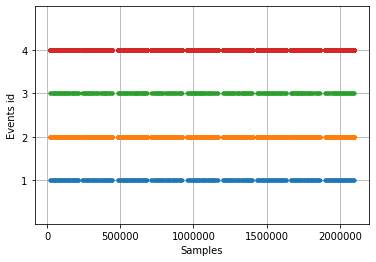

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2107719  =      0.000 ...  2107.719 secs...
Filtering raw data in 9 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.5s finished


13093 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3724 events and 1401 original time points ...
0 bad epochs dropped


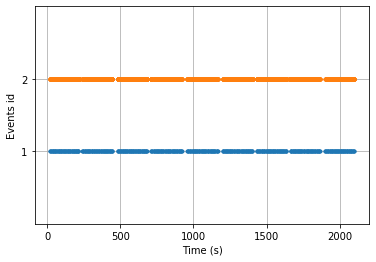

{'1': 1, '2': 2}
1


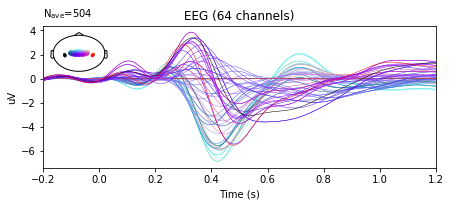

2


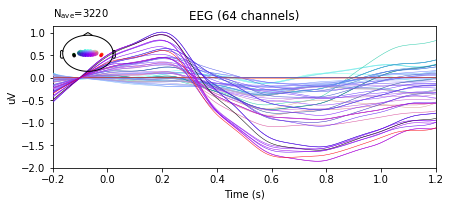

(3724, 64, 141) (3724,)
(3724,) (3724, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 2.6e-10 (2.2e-16 eps * 64 dim * 1.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3724 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3724 events and 1401 original time points ...
0 bad epochs dropped


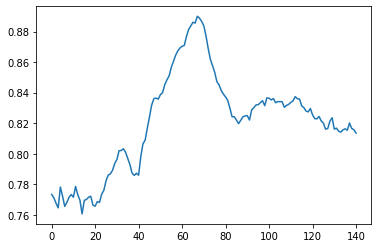

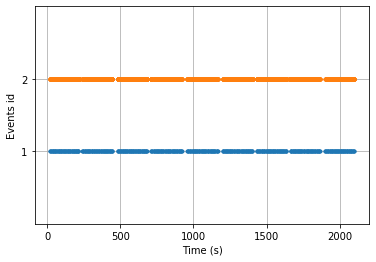

{'1': 1, '2': 2}
1


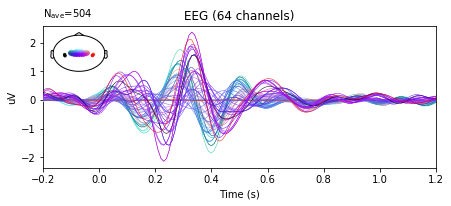

2


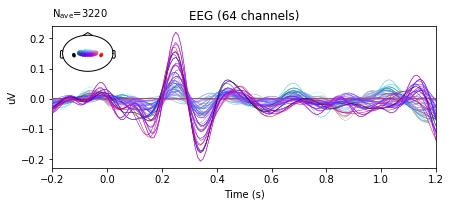

(3724, 64, 141) (3724,)
(3724,) (3724, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.3e-10 (2.2e-16 eps * 64 dim * 8.9e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3724 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3724 events and 1401 original time points ...
0 bad epochs dropped


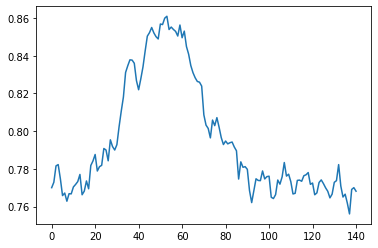

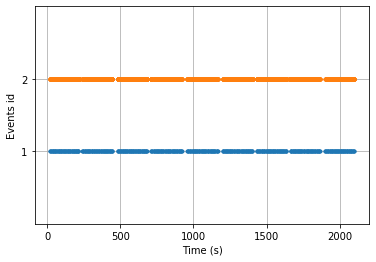

{'1': 1, '2': 2}
1


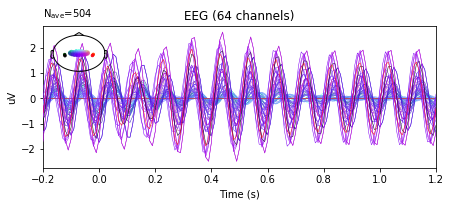

2


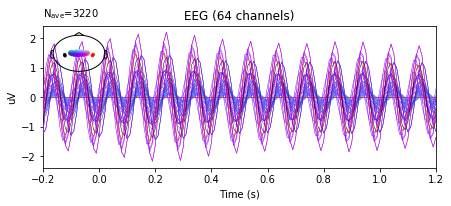

(3724, 64, 141) (3724,)
(3724,) (3724, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 64 dim * 7.7e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3724 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3724 events and 1401 original time points ...
0 bad epochs dropped


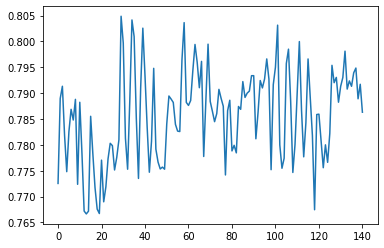

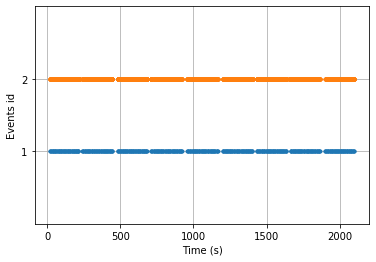

{'1': 1, '2': 2}
1


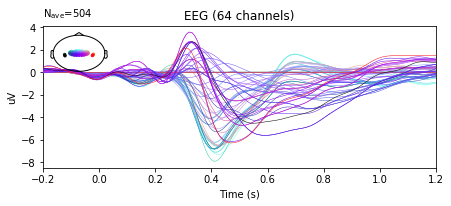

2


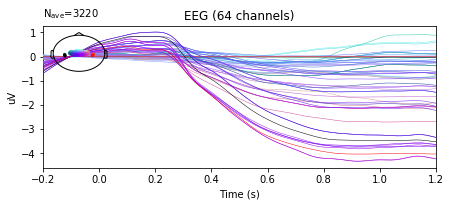

(3724, 64, 141) (3724,)
(3724,) (3724, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.7e-10 (2.2e-16 eps * 64 dim * 2.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.7e-10 (2.2e-16 eps * 64 dim * 2.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3724 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3724 events and 1401 original time points ...
0 bad epochs dropped


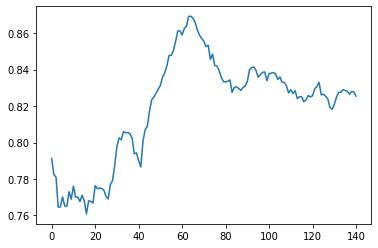

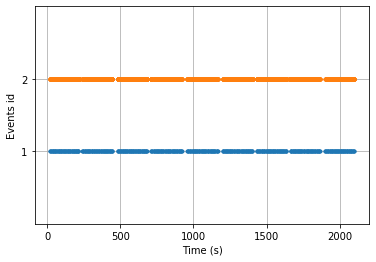

{'1': 1, '2': 2}
1


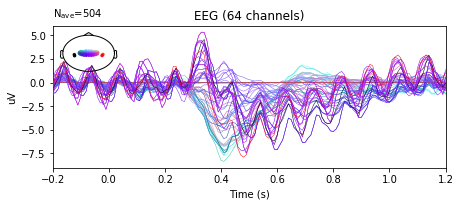

2


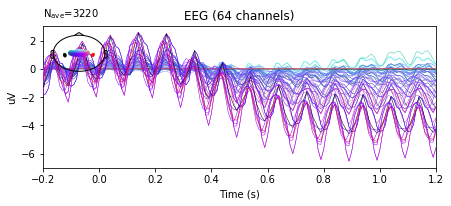

(3724, 64, 141) (3724,)
(3724,) (3724, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4e-10 (2.2e-16 eps * 64 dim * 2.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4e-10 (2.2e-16 eps * 64 dim * 2.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472491
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472632
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

Index: 1950588: 100%|██████████| 504/504 [00:20<00:00, 24.36it/s]


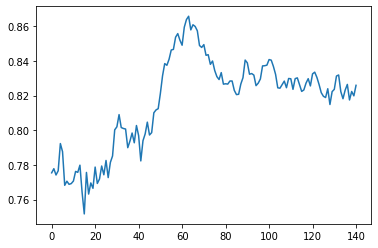

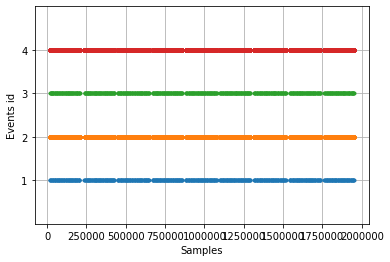

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 1961359  =      0.000 ...  1961.359 secs...
Filtering raw data in 9 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


13115 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3719 events and 1401 original time points ...
0 bad epochs dropped


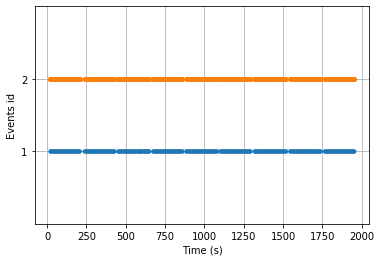

{'1': 1, '2': 2}
1


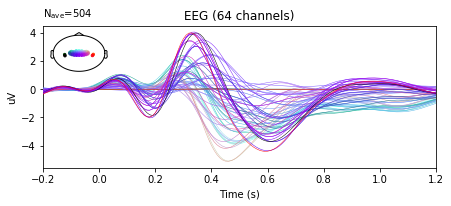

2


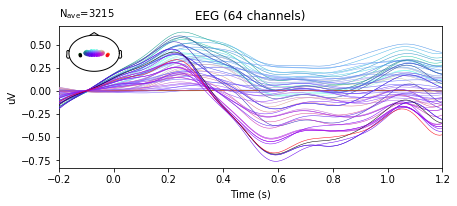

(3719, 64, 141) (3719,)
(3719,) (3719, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 2.3e-10 (2.2e-16 eps * 64 dim * 1.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.7s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.9s finished


3719 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3719 events and 1401 original time points ...
0 bad epochs dropped


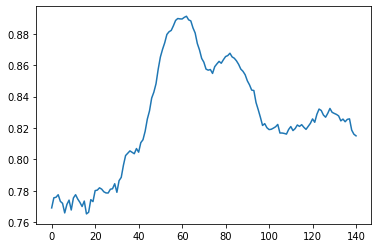

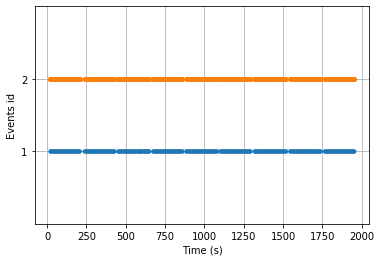

{'1': 1, '2': 2}
1


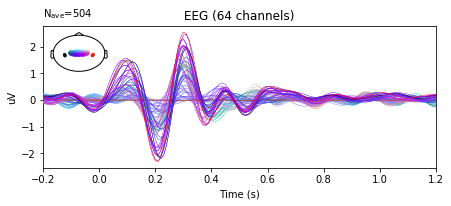

2


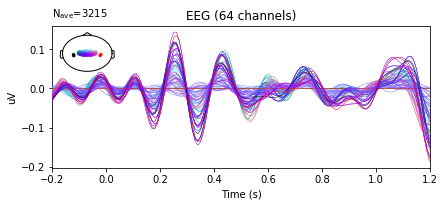

(3719, 64, 141) (3719,)
(3719,) (3719, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.4e-10 (2.2e-16 eps * 64 dim * 1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
In

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3719 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3719 events and 1401 original time points ...
0 bad epochs dropped


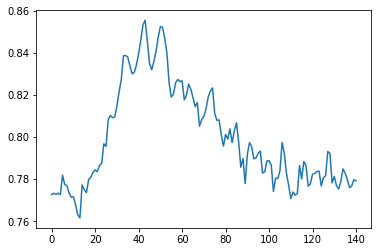

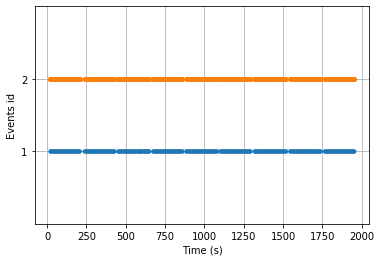

{'1': 1, '2': 2}
1


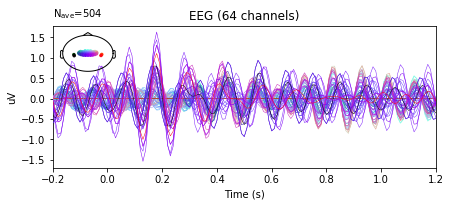

2


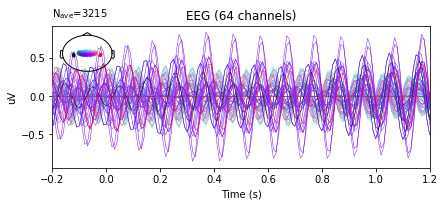

(3719, 64, 141) (3719,)
(3719,) (3719, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.6e-10 (2.2e-16 eps * 64 dim * 1.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3719 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3719 events and 1401 original time points ...
0 bad epochs dropped


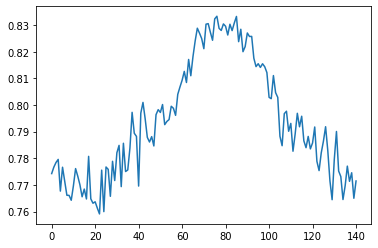

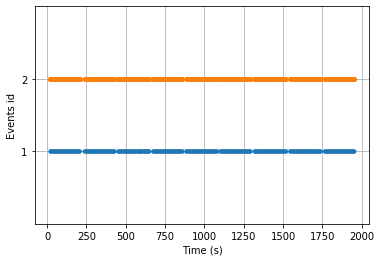

{'1': 1, '2': 2}
1


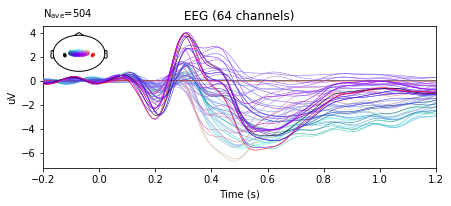

2


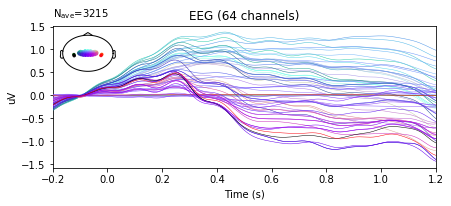

(3719, 64, 141) (3719,)
(3719,) (3719, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471927
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3719 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3719 events and 1401 original time points ...
0 bad epochs dropped


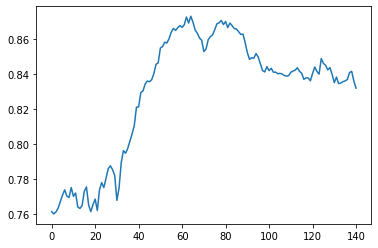

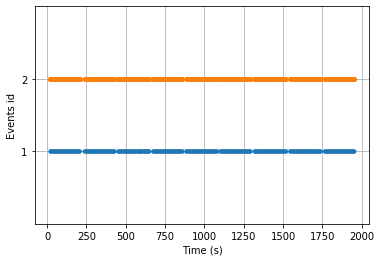

{'1': 1, '2': 2}
1


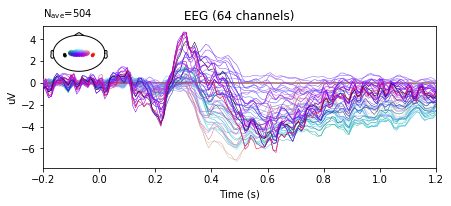

2


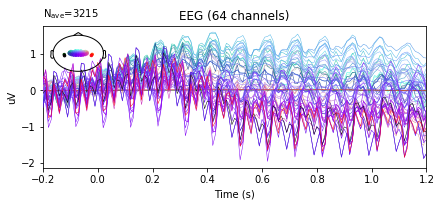

(3719, 64, 141) (3719,)
(3719,) (3719, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471786
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 471927
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.9e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.8e-10 (2.2e-16 eps * 64 dim * 2.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 472068
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

Index: 2385852: 100%|██████████| 560/560 [00:25<00:00, 21.62it/s]


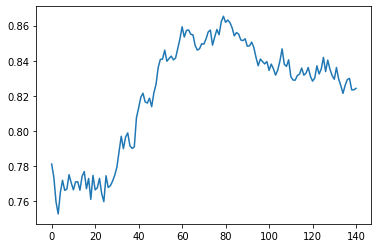

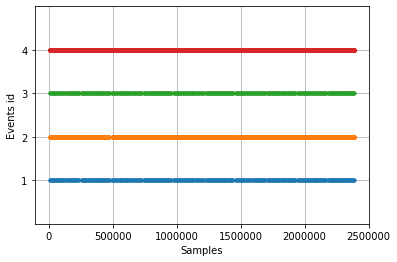

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2394839  =      0.000 ...  2394.839 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


14558 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


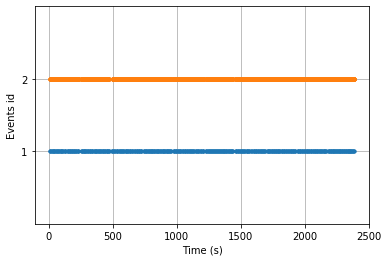

{'1': 1, '2': 2}
1


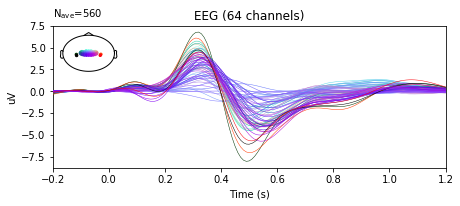

2


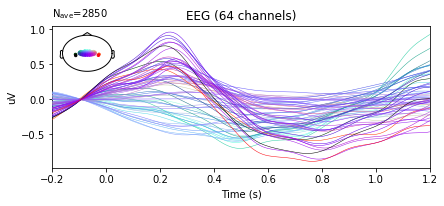

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 2.4e-10 (2.2e-16 eps * 64 dim * 1.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.8s remaining:    4.3s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.8s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.9s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    4.0s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


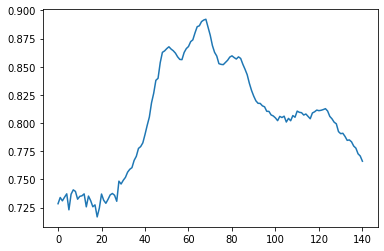

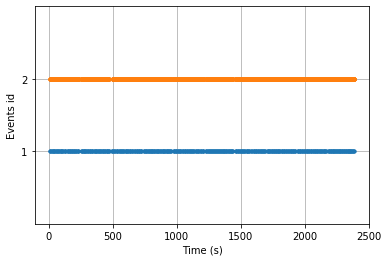

{'1': 1, '2': 2}
1


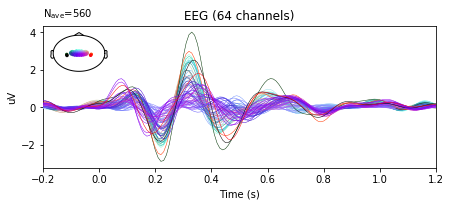

2


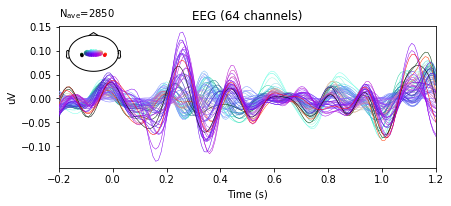

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.2e-10 (2.2e-16 eps * 64 dim * 8.4e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


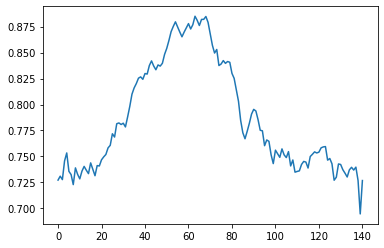

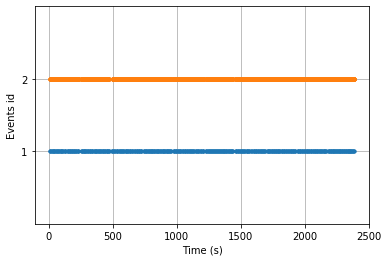

{'1': 1, '2': 2}
1


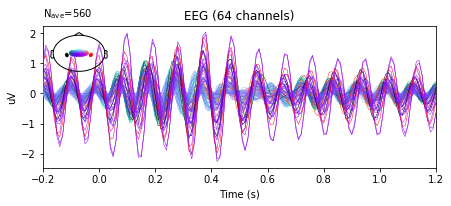

2


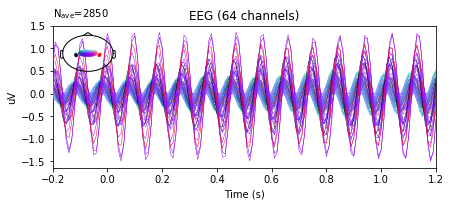

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 9.3e-11 (2.2e-16 eps * 64 dim * 6.5e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


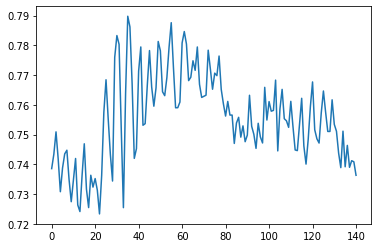

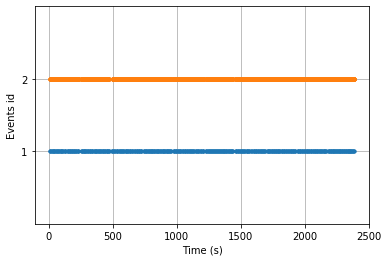

{'1': 1, '2': 2}
1


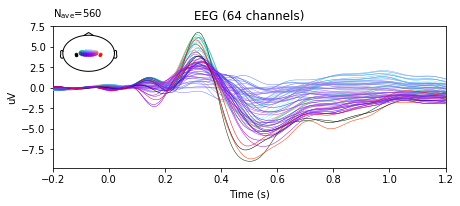

2


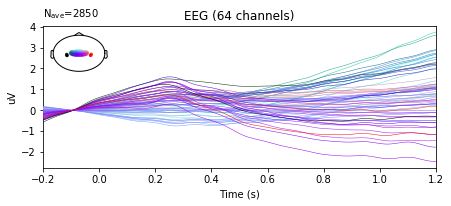

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.9s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


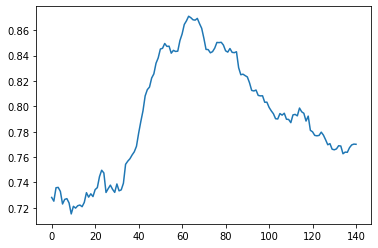

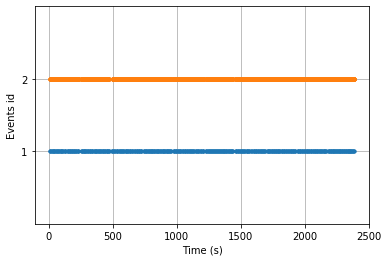

{'1': 1, '2': 2}
1


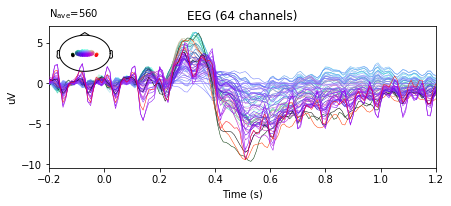

2


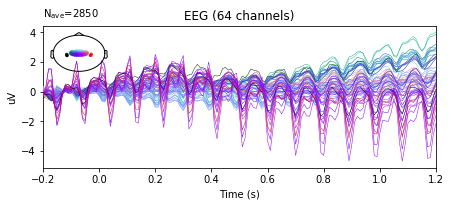

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.7e-10 (2.2e-16 eps * 64 dim * 2.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.6e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 3.5e-10 (2.2e-16 eps * 64 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

Index: 2327843: 100%|██████████| 560/560 [00:26<00:00, 21.52it/s]


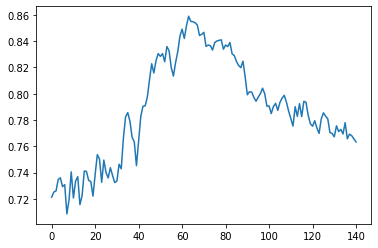

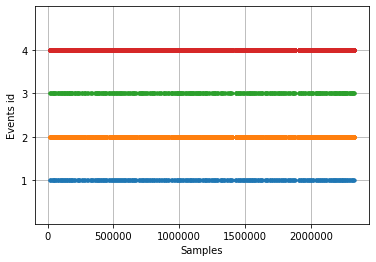

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2333479  =      0.000 ...  2333.479 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


14663 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


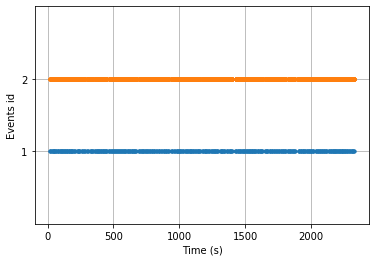

{'1': 1, '2': 2}
1


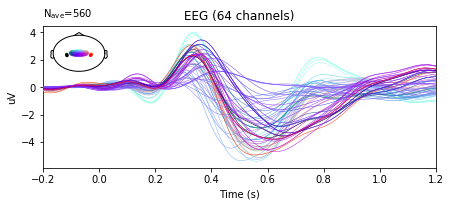

2


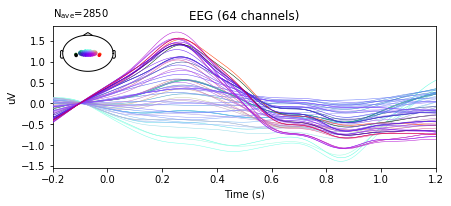

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 64 dim * 2.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.9s remaining:    4.4s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    4.0s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    4.0s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    4.1s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


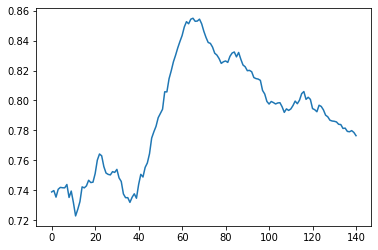

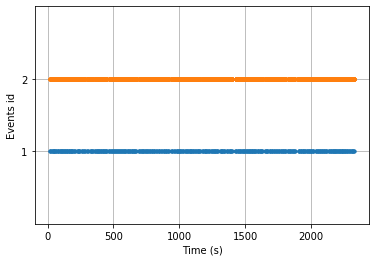

{'1': 1, '2': 2}
1


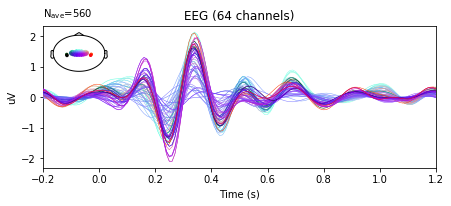

2


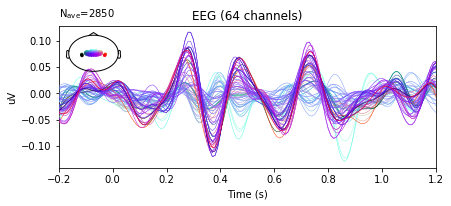

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.6e-10 (2.2e-16 eps * 64 dim * 1.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.8s remaining:    4.3s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.8s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.9s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    4.0s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


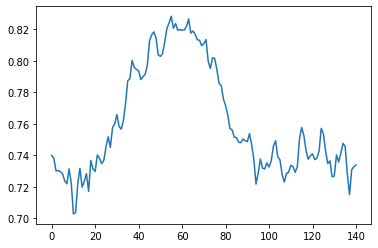

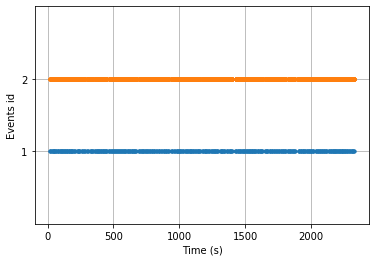

{'1': 1, '2': 2}
1


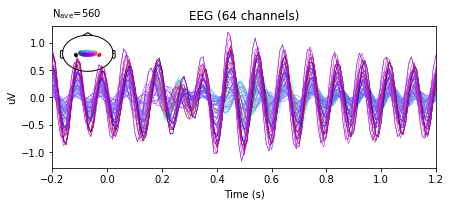

2


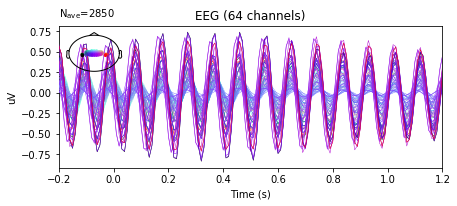

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 64 dim * 7.9e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.9s remaining:    4.5s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    4.0s remaining:    2.0s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    4.1s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    4.2s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


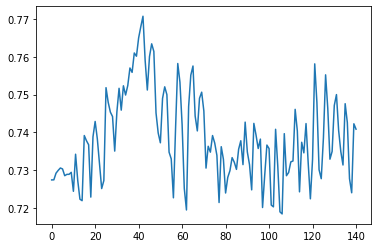

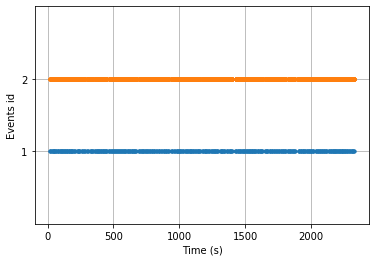

{'1': 1, '2': 2}
1


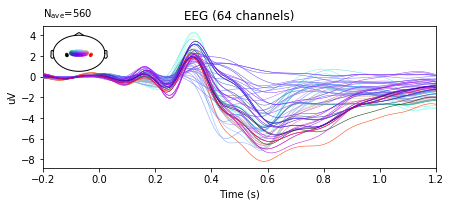

2


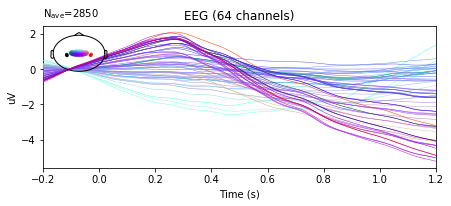

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.9s remaining:    4.4s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    4.0s remaining:    1.9s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    4.0s remaining:    0.6s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    4.1s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


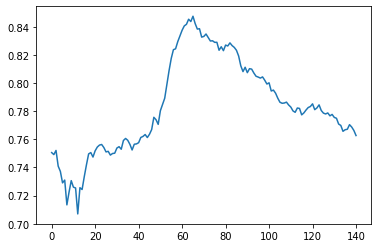

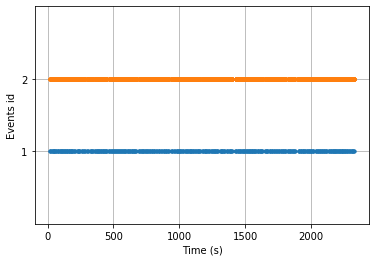

{'1': 1, '2': 2}
1


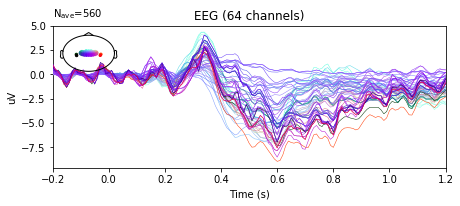

2


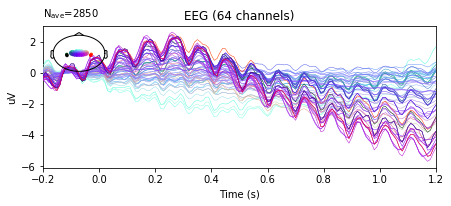

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.1e-10 (2.2e-16 eps * 64 dim * 4.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

Index: 2026142: 100%|██████████| 560/560 [00:25<00:00, 22.20it/s]


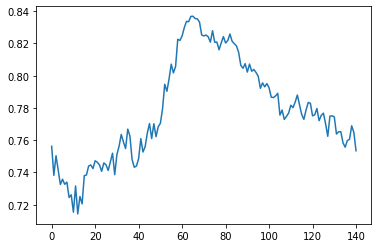

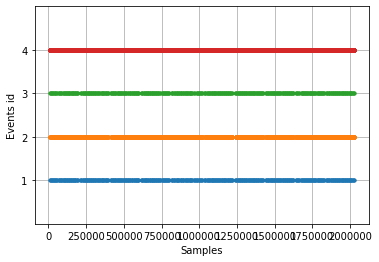

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2031759  =      0.000 ...  2031.759 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


14549 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


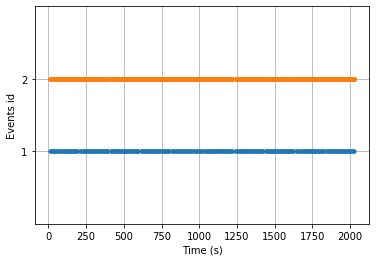

{'1': 1, '2': 2}
1


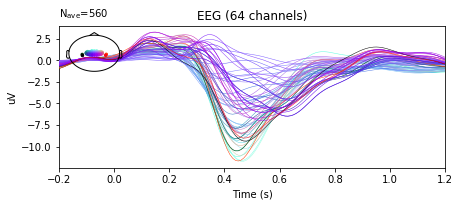

2


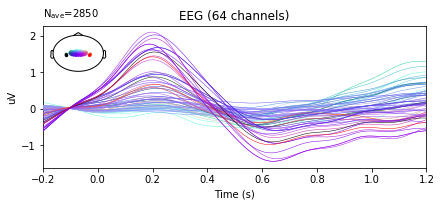

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 3.2e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.3s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.5s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


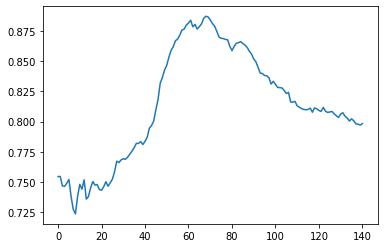

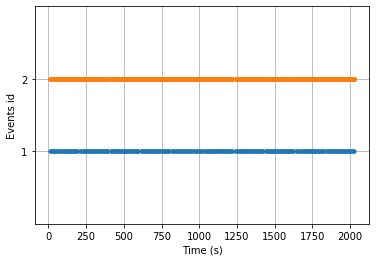

{'1': 1, '2': 2}
1


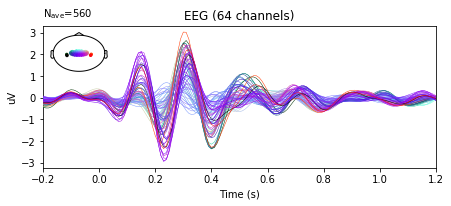

2


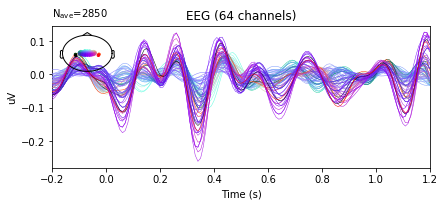

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.5e-10 (2.2e-16 eps * 64 dim * 1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
In

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


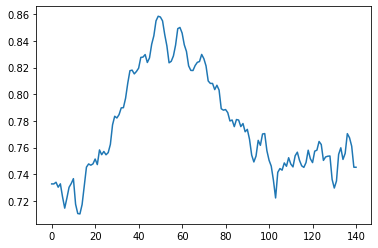

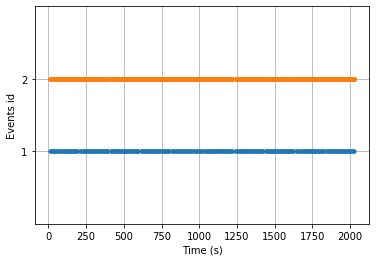

{'1': 1, '2': 2}
1


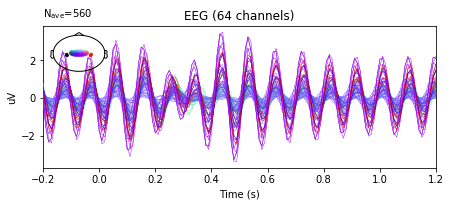

2


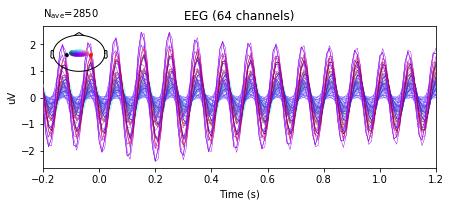

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 64 dim * 7.4e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


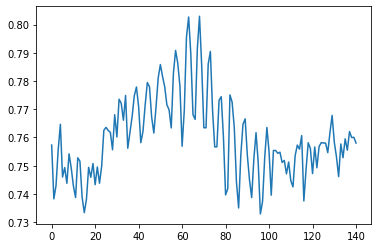

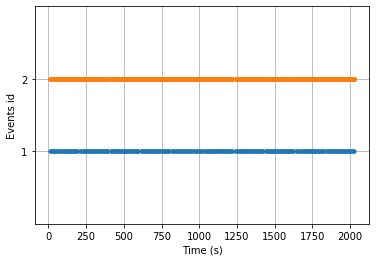

{'1': 1, '2': 2}
1


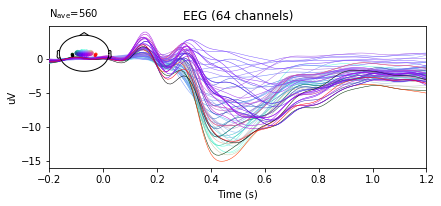

2


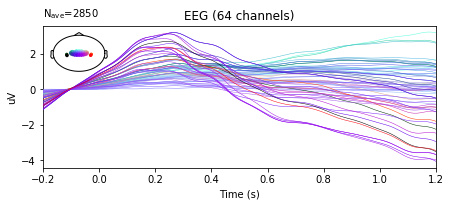

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.5e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.5e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.5e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.5e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.4e-10 (2.2e-16 eps * 64 dim * 3.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.5e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


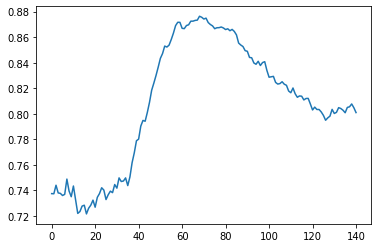

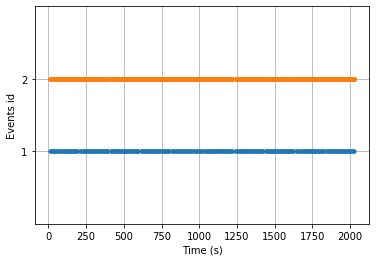

{'1': 1, '2': 2}
1


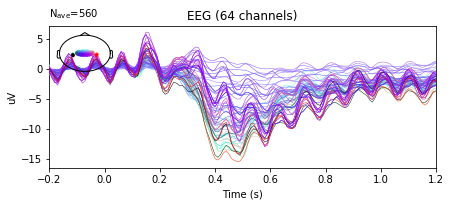

2


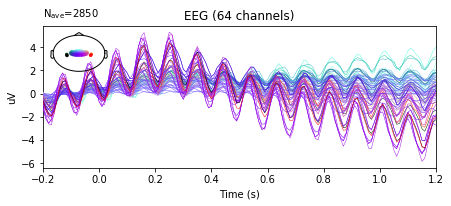

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.6e-10 (2.2e-16 eps * 64 dim * 3.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.7e-10 (2.2e-16 eps * 64 dim * 4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

Index: 1995943: 100%|██████████| 560/560 [00:25<00:00, 22.10it/s]


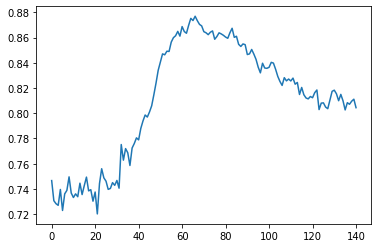

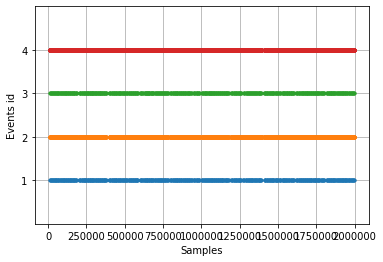

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2001159  =      0.000 ...  2001.159 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


14566 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


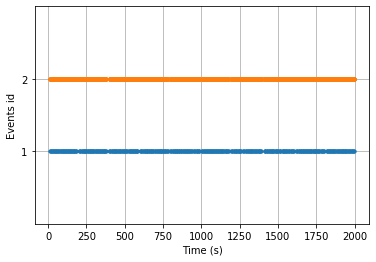

{'1': 1, '2': 2}
1


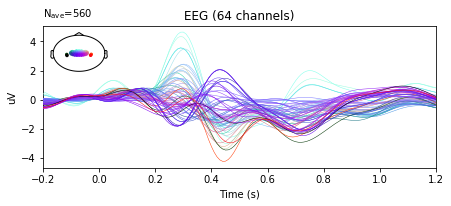

2


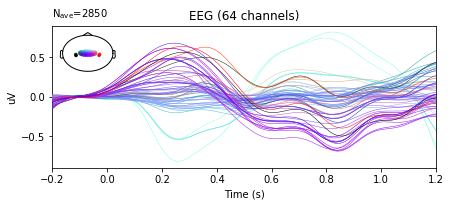

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 3.2e-10 (2.2e-16 eps * 64 dim * 2.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


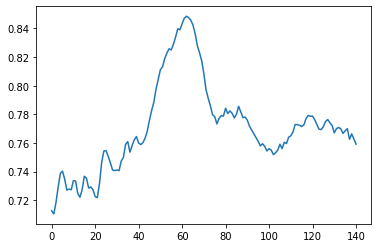

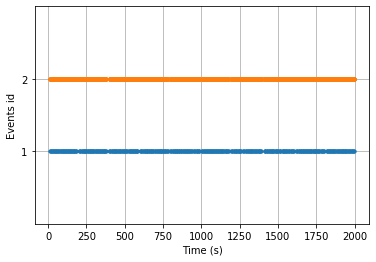

{'1': 1, '2': 2}
1


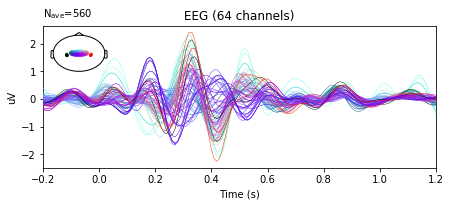

2


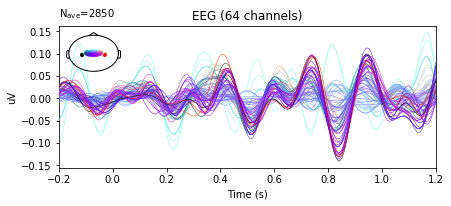

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.7e-10 (2.2e-16 eps * 64 dim * 1.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.5s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


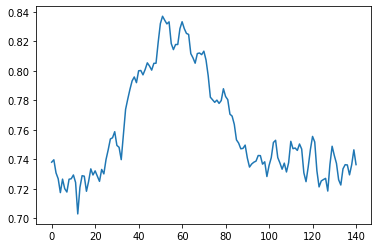

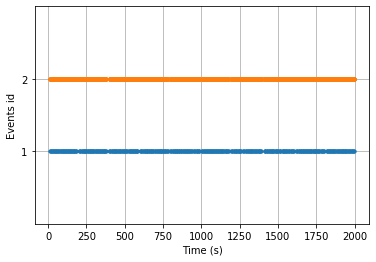

{'1': 1, '2': 2}
1


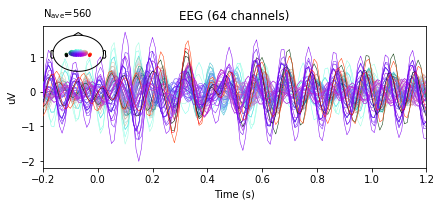

2


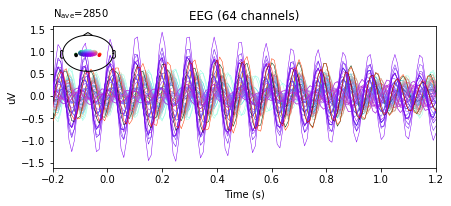

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.9e-10 (2.2e-16 eps * 64 dim * 1.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


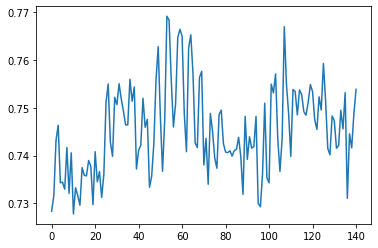

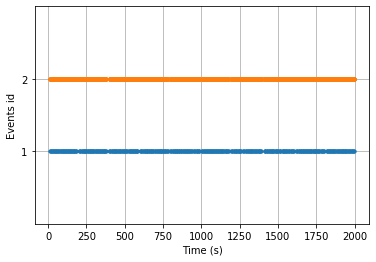

{'1': 1, '2': 2}
1


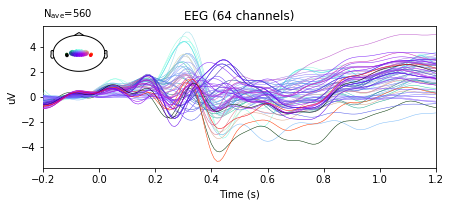

2


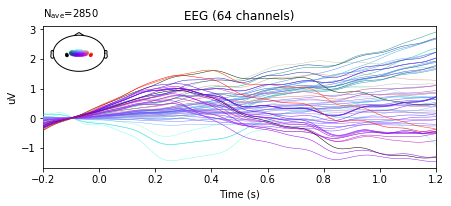

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.1e-10 (2.2e-16 eps * 64 dim * 5.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.1e-10 (2.2e-16 eps * 64 dim * 5.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8e-10 (2.2e-16 eps * 64 dim * 5.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8e-10 (2.2e-16 eps * 64 dim * 5.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.4e-10 (2.2e-16 eps * 64 dim * 4.5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8e-10 (2.2e-16 eps * 64 dim * 5.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.1e-10 (2.2e-16 eps * 64 dim * 5.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.1e-10 (2.2e-16 eps * 64 dim * 5.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


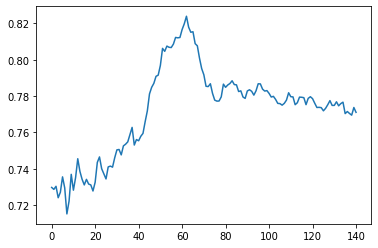

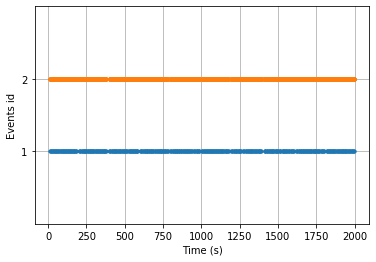

{'1': 1, '2': 2}
1


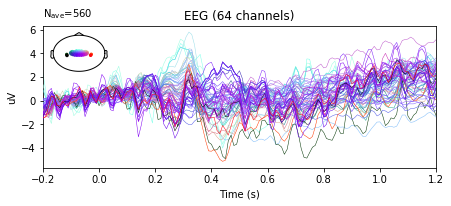

2


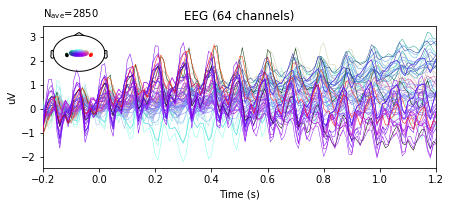

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.8e-10 (2.2e-16 eps * 64 dim * 4.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.4e-10 (2.2e-16 eps * 64 dim * 5.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.3e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.2e-10 (2.2e-16 eps * 64 dim * 5.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 8.4e-10 (2.2e-16 eps * 64 dim * 5.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

Index: 2023659: 100%|██████████| 560/560 [00:26<00:00, 21.24it/s]


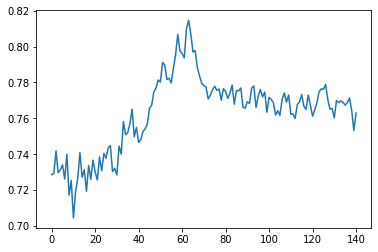

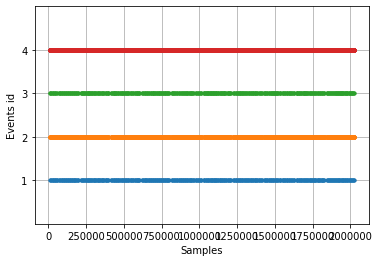

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2029639  =      0.000 ...  2029.639 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


14611 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


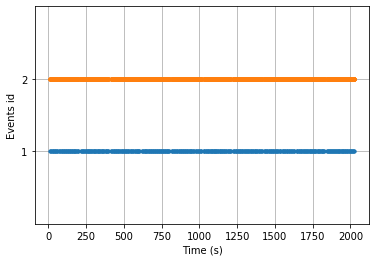

{'1': 1, '2': 2}
1


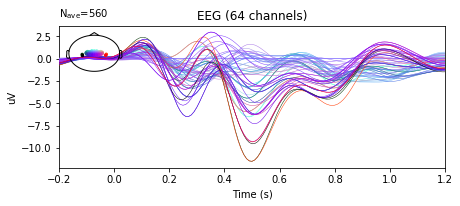

2


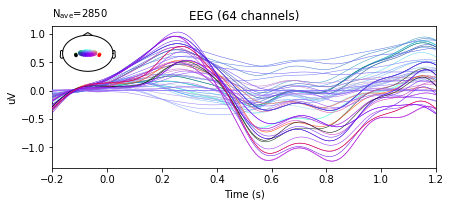

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 3.1e-10 (2.2e-16 eps * 64 dim * 2.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


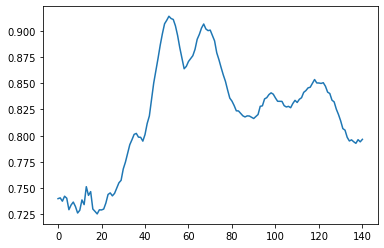

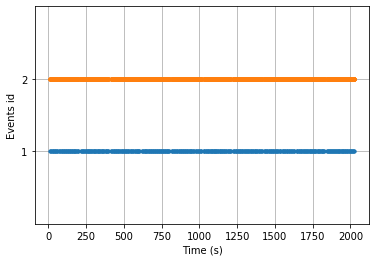

{'1': 1, '2': 2}
1


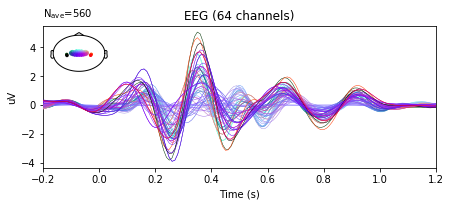

2


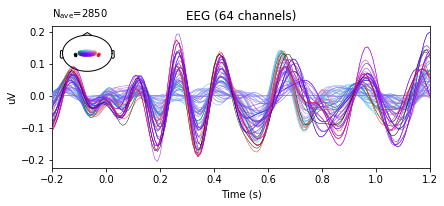

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.9e-10 (2.2e-16 eps * 64 dim * 1.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


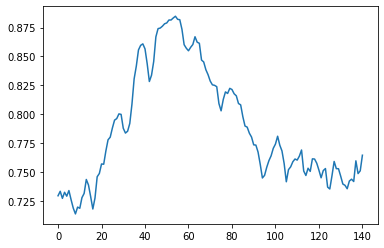

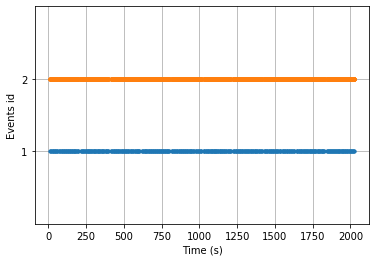

{'1': 1, '2': 2}
1


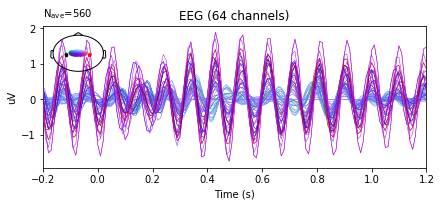

2


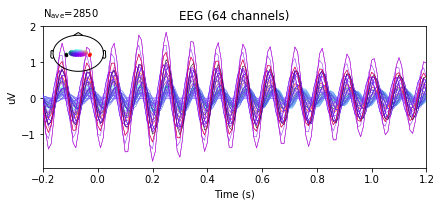

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.6e-10 (2.2e-16 eps * 64 dim * 1.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


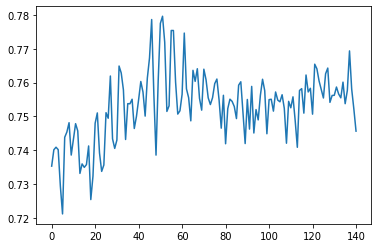

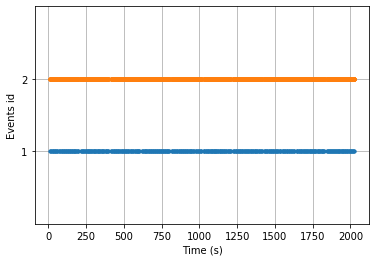

{'1': 1, '2': 2}
1


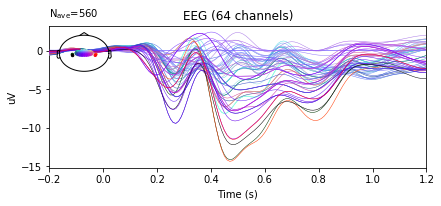

2


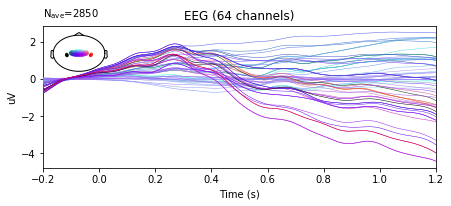

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.7e-10 (2.2e-16 eps * 64 dim * 3.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.7e-10 (2.2e-16 eps * 64 dim * 3.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 64 dim * 3.4e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 4.7e-10 (2.2e-16 eps * 64 dim * 3.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


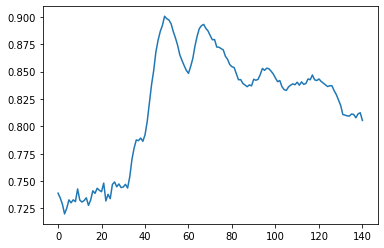

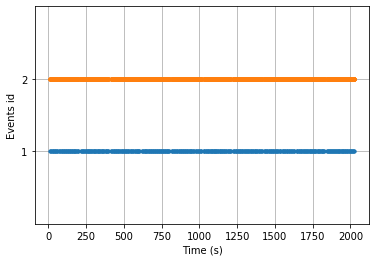

{'1': 1, '2': 2}
1


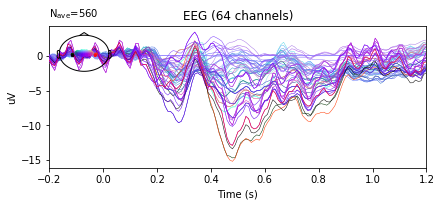

2


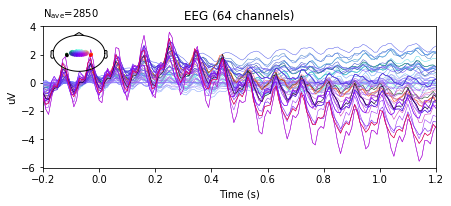

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.3e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.2e-10 (2.2e-16 eps * 64 dim * 3.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

Index: 1925833: 100%|██████████| 560/560 [00:25<00:00, 21.92it/s]


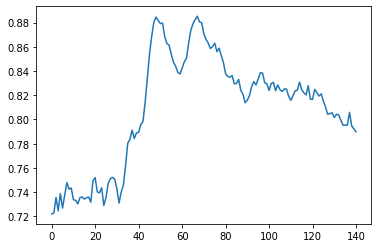

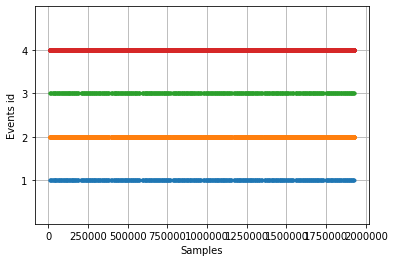

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 1932119  =      0.000 ...  1932.119 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.3s remaining:    3.7s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.5s finished


14568 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


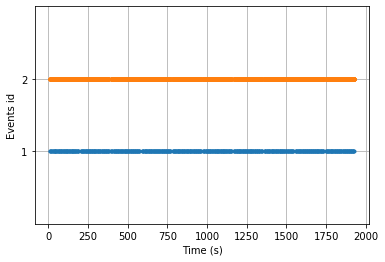

{'1': 1, '2': 2}
1


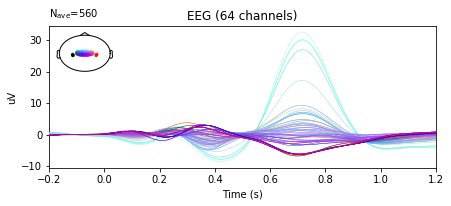

2


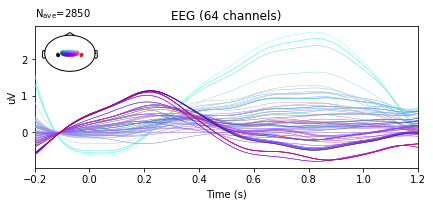

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 5.1e-10 (2.2e-16 eps * 64 dim * 3.6e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.5s remaining:    4.0s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.6s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


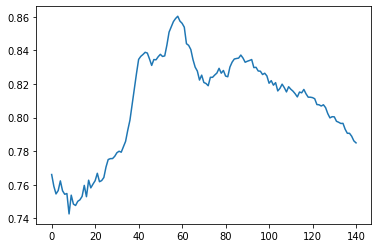

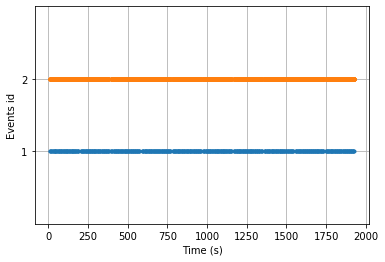

{'1': 1, '2': 2}
1


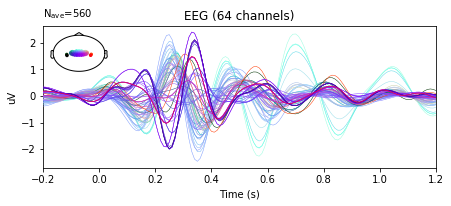

2


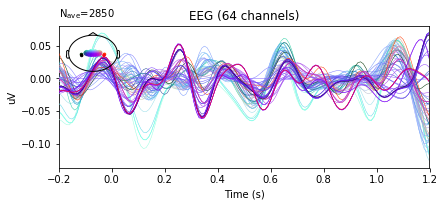

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.4e-10 (2.2e-16 eps * 64 dim * 1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
In

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.9s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.5s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.7s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


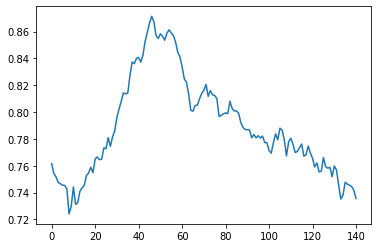

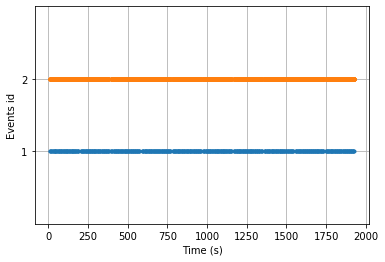

{'1': 1, '2': 2}
1


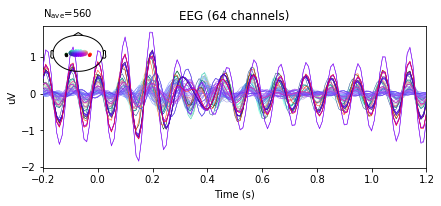

2


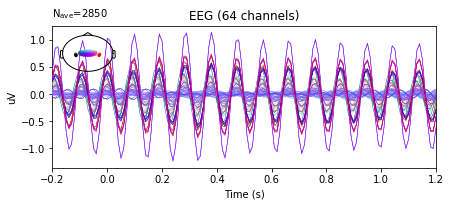

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 7.8e-11 (2.2e-16 eps * 64 dim * 5.5e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.9s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


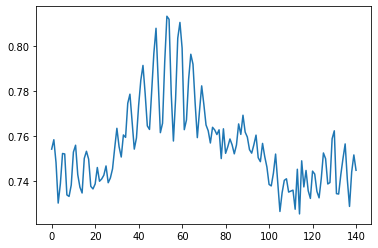

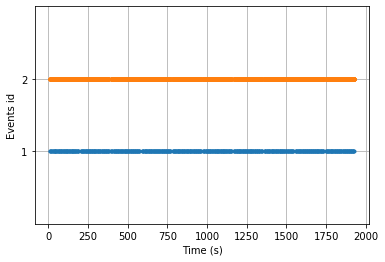

{'1': 1, '2': 2}
1


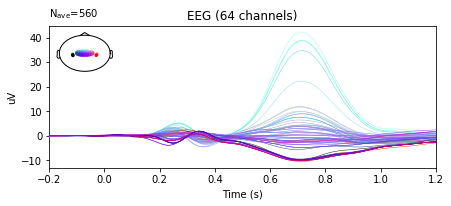

2


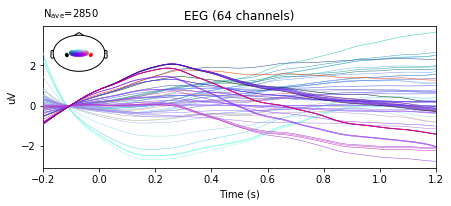

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.8e-10 (2.2e-16 eps * 64 dim * 4.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.8e-10 (2.2e-16 eps * 64 dim * 4.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.8e-10 (2.2e-16 eps * 64 dim * 4.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.8e-10 (2.2e-16 eps * 64 dim * 4.1e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.7e-10 (2.2e-16 eps * 64 dim * 4.7e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.4s remaining:    3.8s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.4s remaining:    1.7s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.6s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


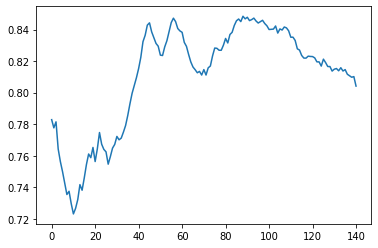

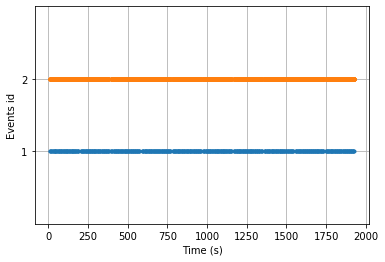

{'1': 1, '2': 2}
1


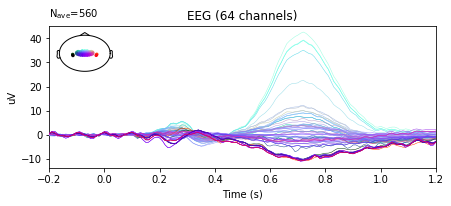

2


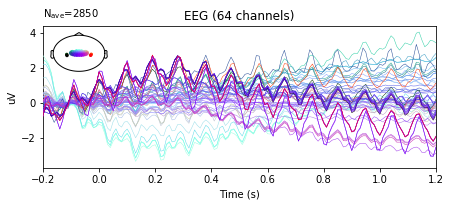

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.


<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7.1e-10 (2.2e-16 eps * 64 dim * 5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.9e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 64 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 6.8e-10 (2.2e-16 eps * 64 dim * 4.8e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 5e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 

<ipython-input-4-4e47ad578f0d>:9: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs[train], method='diagonal_fixed', n_jobs=n_jobs)


Computing data rank from raw with rank=None
    Using tolerance 7e-10 (2.2e-16 eps * 64 dim * 4.9e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 5

Index: 2089541: 100%|██████████| 560/560 [00:26<00:00, 21.45it/s]


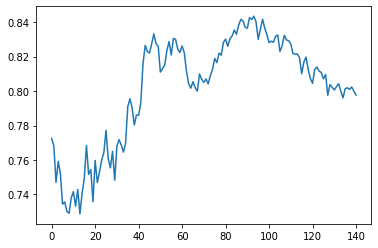

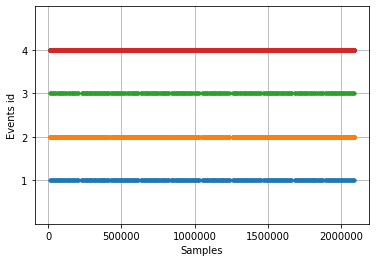

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2096839  =      0.000 ...  2096.839 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.6s remaining:    4.1s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.7s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.8s finished


14526 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


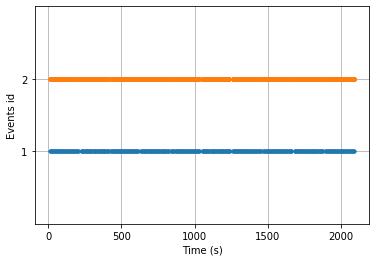

{'1': 1, '2': 2}
1


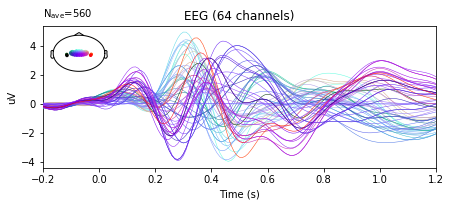

2


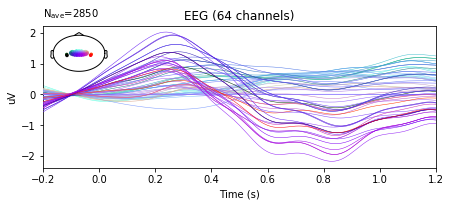

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 3.3e-10 (2.2e-16 eps * 64 dim * 2.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    3.7s remaining:    4.2s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.8s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.8s remaining:    0.5s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.9s finished


3410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


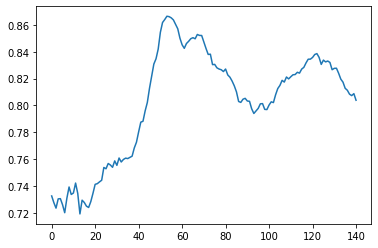

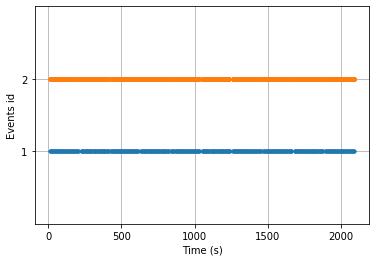

{'1': 1, '2': 2}
1


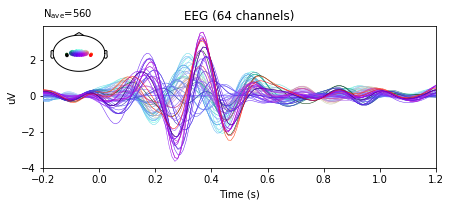

2


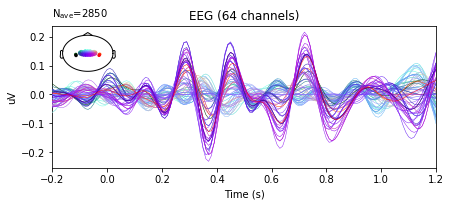

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict_times starts.
Computing data rank from raw with rank=None
    Using tolerance 1.9e-10 (2.2e-16 eps * 64 dim * 1.3e+04  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Number of samples used : 432729
[done]
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 58 Xdawn components


In [ ]:
for exper in autodf.index:
    print('-' * 80)
    print(exper)
    if os.path.exists('MVPA_predicts_{}.json'.format(exper)):
        continue
    rawraw = mne.concatenate_raws([mne.io.read_raw_fif(os.path.join('processed_data', exper, e)) for e in os.listdir(os.path.join('processed_data', exper)) if e.endswith('_ica-raw.fif')])

    MVPA_predict_df = pd.DataFrame()

    # Filter events
    events = False
    if exper.startswith('MEG'):
        picks = 'mag'
        decim = 12
        events = mne.find_events(rawraw, stim_channel='UPPT001')
    if exper.startswith('EEG'):
        picks = 'eeg'
        decim = 10
        events = mne.events_from_annotations(rawraw)[0]
    assert(events is not False)
    
    sfreq = rawraw.info['sfreq']
    with tqdm.tqdm(events[events[:, -1]==1]) as pbar:
        for e in pbar:
            pbar.set_description('Index: {}'.format(e[0]))
            for ee in events:
                if all([ee[-1] == 2, abs(ee[0]-e[0])<sfreq]):
                    ee[-1] = 4
    mne.viz.plot_events(events)

    for freqs in iter_freqs:
        print('-' * 80)
        print(freqs)
        name_freq, l_freq, h_freq = freqs
        
        # Copy raw and filter rr
        rr = rawraw.copy()
        rr.load_data()
        rr.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)

        # Get epochs
        # Raw epochs
        epochs = mne.Epochs(rr, events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
        # Clear events
        epochs = epochs[['1', '2']]
        epochs.load_data()

        event_id = epochs.event_id
        # Get and plot events
        events = epochs.events
        mne.viz.plot_events(events, sfreq=sfreq)
        print(event_id)
        # Plot epochs
        for event in event_id:
            print(event)
            epochs[event].average().plot(spatial_colors=True)

        # perform MVPA
        # MVPA_predicts = perform_MVPA(epochs.copy())
        # Report MVPA
        # report_MVPA(MVPA_predicts)
        # MVPA_results[name_freq].append(('origin', MVPA_predicts))

        # perform xdawn MVPA
        xdawn_MVPA_predicts = perform_MVPA(epochs.copy())
        # Report xdawn MVPA
        report_MVPA(xdawn_MVPA_predicts)
        
        # stophere
        
        MVPA_predict_df = MVPA_predict_df.append(pd.Series(xdawn_MVPA_predicts, name=name_freq))

    MVPA_predict_df.to_json('MVPA_predicts_{}.json'.format(exper))